# <div align="center"> 花 </div>

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
matplotlib 3.2.1
sklearn 0.23.1
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101


In [8]:
import pandas as pd  
import argparse      
import shutil        
import os            
import random
import numpy as np
import json

import torch
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from IPython.display import display, Markdown
from PIL import Image

from torchvision.utils import make_grid

from k12libs.utils.nb_dataset import k12ai_compute_mean_std

In [3]:
en_names = [
  'salviasplendens',
  'daffodil',
  'snowdrop',
  'lilyvalley',
  'bluebell',
  'crocus',
  'iris',
  'tigerlily',
  'tulip',
  'fritillary',
  'sunflower',
  'daisy',
  'coltsfoot',
  'dandelion',
  'cowslip',
  'buttercup',
  'windflower',
  'pansy',
  'coxcomb',
  'flamingo',
  'lily',
  'lotus']

cn_names = [
'鼠尾草',
'水仙花',
'雪花莲',
'铃兰花',
'野风信子',
'番红花',
'鸢尾花',
'卷丹',
'郁金香',
'豹纹蝶',
'向日葵',
'雏菊',
'款冬',
'蒲公英',
'黄花九轮草',
'毛茛',
'白头翁',
'蝴蝶花',
'鸡冠花',
'红鹤',
'百合花',
'荷花'
]

table = '''
标签(label) | 英文(en_name) | 中文(cn_name)
:---: | :---: | :---:
<img width=200/> | <img width=200/> |<img width=200/>
'''

for i in range(len(en_names)):
    table += f'{i} | {en_names[i]} | {cn_names[i]} \n'
    
Markdown(table)


标签(label) | 英文(en_name) | 中文(cn_name)
:---: | :---: | :---:
<img width=200/> | <img width=200/> |<img width=200/>
0 | salviasplendens | 鼠尾草 
1 | daffodil | 水仙花 
2 | snowdrop | 雪花莲 
3 | lilyvalley | 铃兰花 
4 | bluebell | 野风信子 
5 | crocus | 番红花 
6 | iris | 鸢尾花 
7 | tigerlily | 卷丹 
8 | tulip | 郁金香 
9 | fritillary | 豹纹蝶 
10 | sunflower | 向日葵 
11 | daisy | 雏菊 
12 | coltsfoot | 款冬 
13 | dandelion | 蒲公英 
14 | cowslip | 黄花九轮草 
15 | buttercup | 毛茛 
16 | windflower | 白头翁 
17 | pansy | 蝴蝶花 
18 | coxcomb | 鸡冠花 
19 | flamingo | 红鹤 
20 | lily | 百合花 
21 | lotus | 荷花 


In [2]:
dataset = 'rflowers'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
raw_path = os.path.join(data_root, 'raw')
img_path = os.path.join(data_root, 'imgs')

## 原始数据处理

In [3]:
label_image_dict = {}
with os.scandir(raw_path) as it:
    for entry in it:
        if not entry.is_dir():
            continue
        label_image_dict[entry.name] = []
        with os.scandir(os.path.join(entry.path)) as imgit:
            for imgentry in imgit:
                if not imgentry.is_file():
                    continue
                label_image_dict[entry.name].append(imgentry.path)
len(label_image_dict), len(label_image_dict['21']), label_image_dict.keys()

(22,
 80,
 dict_keys(['17', '8', '18', '15', '4', '6', '1', '0', '3', '11', '13', '10', '12', '14', '19', '20', '2', '9', '7', '16', '5', '21']))

## 裁剪

In [4]:
if os.path.exists(img_path):
    shutil.rmtree(img_path)
os.makedirs(img_path)

label_images = {}
for label, files in label_image_dict.items():
    d = os.path.join(img_path, label)
    os.makedirs(d)
    label_images[label] = []
    for img in files:
        dst = os.path.join(d, os.path.basename(img))
        Image.open(img).resize((256, 256)).crop((16, 16, 240, 240)).save(dst)
        label_images[label].append(dst)
len(label_images), len(label_images['21'])

(22, 80)

## 对比

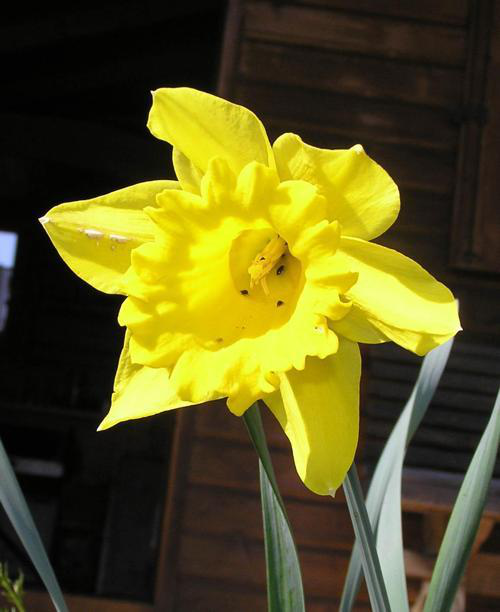

In [5]:
Image.open(label_image_dict['1'][0])

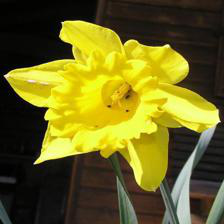

In [6]:
Image.open(label_images['1'][0])

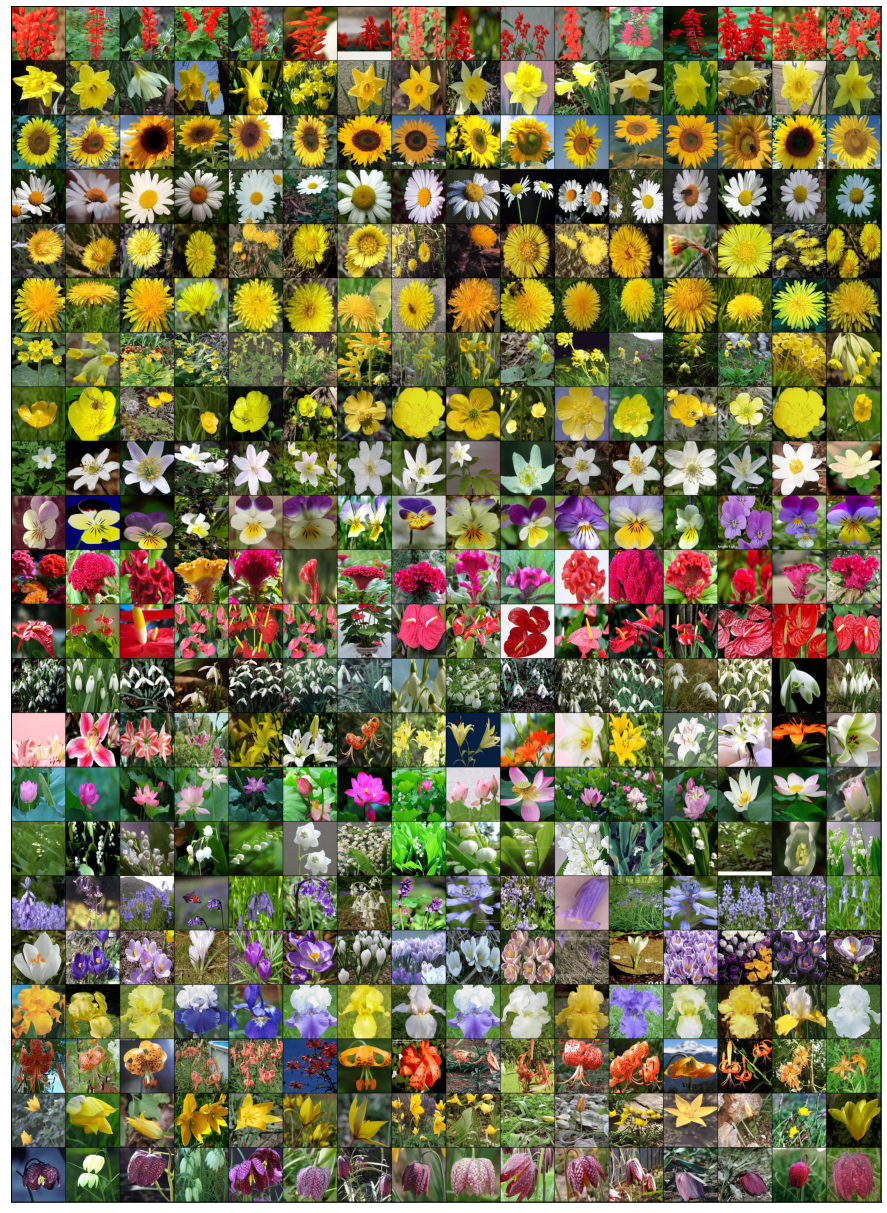

In [13]:
samples = []
for label in sorted(list(label_images.keys())):
    for img in label_images[label][:16]:
        samples.append(torch.from_numpy(np.asarray(Image.open(img))).permute(2, 0, 1))
    
fig, ax = plt.subplots(figsize=(16, 22))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(samples, nrow=16).permute(1, 2, 0))

## 切割数据集

In [16]:
# 6:2:2 split for train:valid:test dataset
all_images = []
test_images = []
valid_images = []
train_images = []
for label, files in label_images.items():
    for img in files:
        all_images.append((label, img))
        value = random.random()
        if value < 0.2: # test
            test_images.append((label, img))
        elif value < 0.4: # val
            valid_images.append((label, img))
        else: # train
            train_images.append((label, img))
test_count, val_count, train_count = len(test_images), len(valid_images), len(train_images)
test_count, val_count, train_count

(372, 347, 1041)

## 生成json文件

In [17]:
def generate_json_file(images, phase):
    prefix = len(data_root) + 1
    items = []
    for label, img in images:
        items.append({'image_path': img[prefix:], 'label': int(label)})
        
    random.shuffle(items)

    jsonfile = os.path.join(data_root, f'{phase}.json')
    with open(jsonfile, 'w') as fp:
        json.dump(items, fp)
    return len(items)
        
# train.json
generate_json_file(train_images, 'train');

# val.json
generate_json_file(valid_images, 'val');

# test.json
generate_json_file(test_images, 'test');

# all.json
generate_json_file(all_images, 'all');

In [10]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles, resize=(224, 224))

## 生成info.json

In [11]:
label_names = [
    "salviasplendens",
    "daffodil",
    "snowdrop",
    "lilyvalley",
    "bluebell",
    "crocus",
    "iris",
    "tigerlily",
    "tulip",
    "fritillary",
    "sunflower",
    "daisy",
    "coltsfoot",
    "dandelion",
    "cowslip",
    "buttercup",
    "windflower",
    "pansy",
    "coxcomb",
    "flamingo",
    "lily",
    "lotus"
]

info = {
    'num_records': test_count+val_count+train_count,
    'num_classes': len(label_names),
    'label_names': label_names,
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, indent=4)
    
info

{'num_records': 1760,
 'num_classes': 22,
 'label_names': ['salviasplendens',
  'daffodil',
  'snowdrop',
  'lilyvalley',
  'bluebell',
  'crocus',
  'iris',
  'tigerlily',
  'tulip',
  'fritillary',
  'sunflower',
  'daisy',
  'coltsfoot',
  'dandelion',
  'cowslip',
  'buttercup',
  'windflower',
  'pansy',
  'coxcomb',
  'flamingo',
  'lily',
  'lotus'],
 'mean': [0.4623, 0.4305, 0.295],
 'std': [0.252, 0.2242, 0.2091]}

## 数据平衡分析

<Figure size 432x288 with 0 Axes>

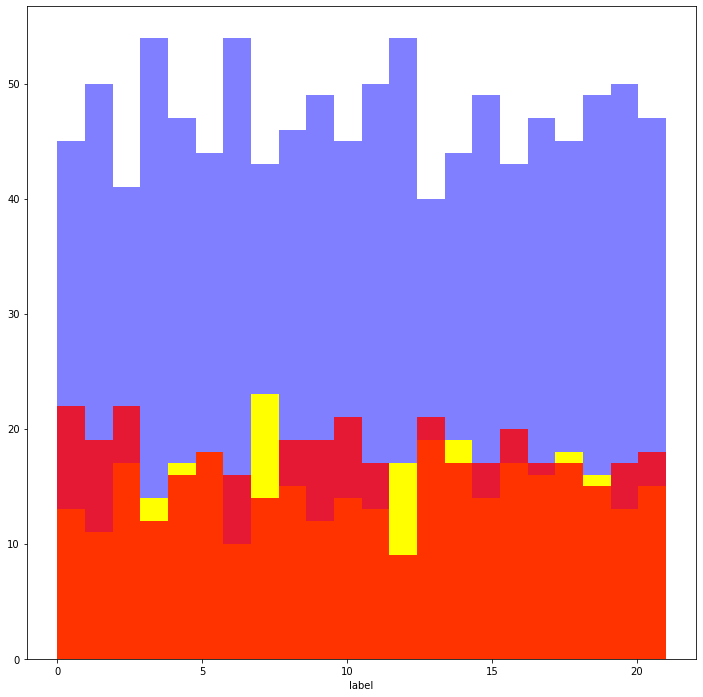

In [12]:
def draw_hist():
    plt.clf()
    fig = plt.figure(figsize=(12, 12))
    train_file = os.path.join(data_root, 'train.json')
    val_file = os.path.join(data_root, 'val.json')
    test_file = os.path.join(data_root, 'test.json')
    df_train = pd.read_json(train_file)
    df_val = pd.read_json(val_file)
    df_test = pd.read_json(test_file)
    for df, co, alpha in ((df_train, 'blue', 0.5), (df_val, 'yellow', 1), (df_test, 'red', 0.8)):
        sns.distplot(df['label'],
                 # fit=scipy.stats.norm,
                 kde=False,
                 hist=True,
                 hist_kws={"linewidth": 2, "alpha": alpha, 'color': co},
                 # rug=True,
                 bins=22)
    plt.savefig(f'{data_root}/labels_hist.png')
    plt.show()
draw_hist()

## References

[百度数据集](https://aistudio.baidu.com/aistudio/datasetdetail/20653)